# Прогноз вероятности оттока клиентов в сети фитнес-центров

## План исследования
- спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    - выделить целевые группы клиентов;
    - предложить меры по снижению оттока;
    - определить другие особенности взаимодействия с клиентами.
    
## Описание данных    
Заказчик подготовил данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:

Данные клиента за предыдущий (до проверки факта оттока) месяц:
- `gender` — пол;
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- `Phone` — наличие контактного телефона;
- `Age` — возраст;
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `Group_visits` — факт посещения групповых занятий;
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- `Churn` — факт оттока в текущем месяце.

# Загрузка и подготовка данных

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
# загрузка данных
data = pd.read_csv('gym_churn.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
# приведение названий столбцов к нижнему регистру
data.columns = data.columns.str.lower()
data.info()
print('\nКол-во полных дубликатов в данных:', data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

**Промежуточный вывод**

В данных содержится 4 тысячи строк и 14 столбцов. Пропусков не обнаружено, тип данных указан верно, названия столбцов соответствуют стандарту оформления, дубликаты отсутствуют.

# Исследовательский анализ данных

In [4]:
# изучим данные методом describe()
data.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


В общем виде аномалий в данных замечено не было. Из наблюдений видно, что большинство клиентов проживает в том же районе, где расположен фитнес центр (в среднем 84,5% клиентов). Возрастная категория представлена от 18 лет до 41 года, средний возраст клиента - 29 лет. Средняя посещаемость в неделю составляет 2 дня, а средний отток - 26,5% пользователей.

In [5]:
# посмотрим на средние значения признаков для тех, кто ушел (1) и тех, кто остался (0)
group_by_churn = data.groupby('churn').agg('mean')
group_by_churn.T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Для ушедших пользователей характерно: 
- проживающих в другом районе в среднем на 11% больше;
- доля клиентов, являющихся сотрудниками компаний-партнеров, составила 35%, в то время как у оставшихся пользователей доля составиляет 53%;
- доля клиентов, пришедших в фитнес клуб по акции "Приведи друга" составила 18%, в то время как у оставшихся пользователей доля составляет 35%;
- длительность текущего действующего абонемента ниже, чем у оставшихся пользователей, в среднем в 3 раза. Скорее всего, для ушедших пользователей характерна покупка абонемента на 1 месяц, а для оставшихся пользователей - от 6 месяцев и выше;
- групповые занятия посещали в среднем 27% клиентов (у оставшихся доля составляет 46%);
- возраст ушедших пользователей ниже и составил 27 лет, у оставшихся пользователей средний возраст 30 лет;
- средняя выручка от смежных услуг составила 115 у.е., в то время как у активных пользователей она составляет 158 у.е.;
- время с момента первого обращения в фитнес-центр в среднем составило 1 месяц, в то время как у активных пользователей этот показатель в среднем 4,7 месяца;
- ушедшие пользователи реже посещали фитнес-центр, особенно в последний месяц (1 день в неделю против 2 дней у активных пользователей).

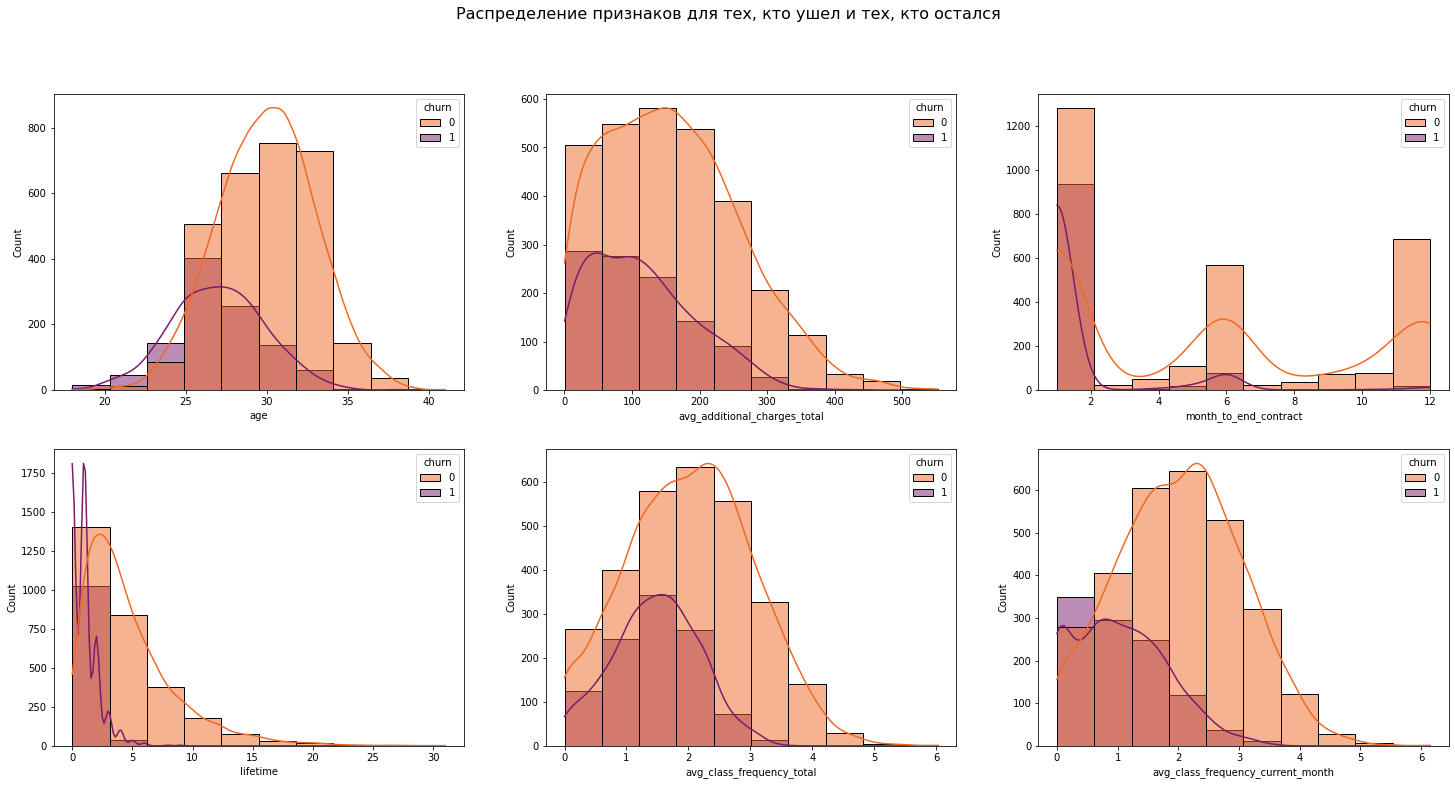

In [6]:
# построение гистограмм признаков для тех, кто ушёл (отток) и тех, кто остался (не попал в отток)
num_features = [
    'age',
    'avg_additional_charges_total',
    'month_to_end_contract',
    'lifetime',
    'avg_class_frequency_total',
    'avg_class_frequency_current_month'
]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25,12))
fig.suptitle('Распределение признаков для тех, кто ушел и тех, кто остался', fontsize=16)
for i in range(len(num_features)):
    sns.histplot(data,
                 x = num_features[i],
                 kde = True,
                 hue = 'churn',
                 ax = axes.flatten()[i],
                 bins = 10,
                 palette = 'inferno_r')

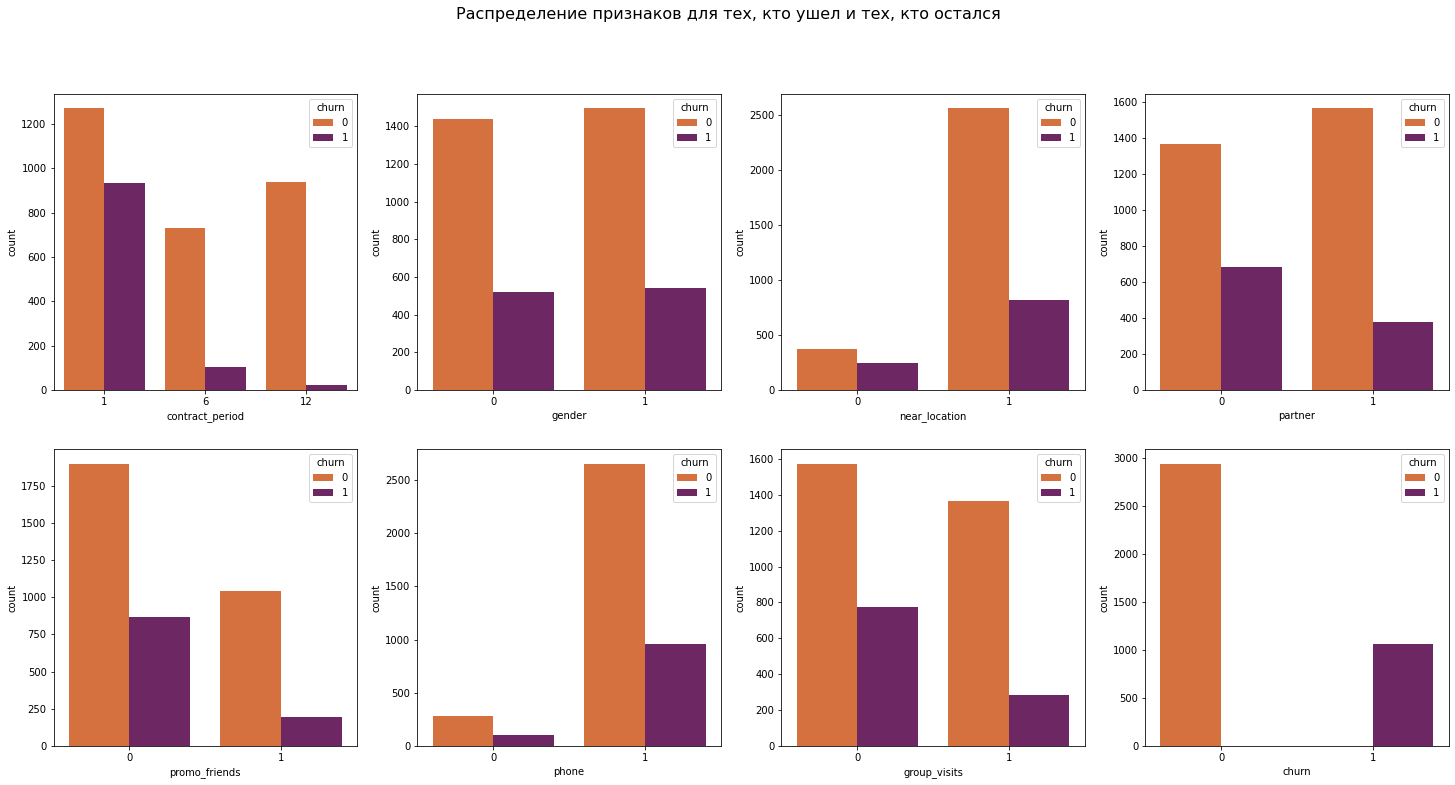

In [7]:
# построение гистограмм признаков для тех, кто ушёл (отток) и тех, кто остался (не попал в отток)
num_features_2 = [
    'contract_period',
    'gender',
    'near_location',
    'partner',
    'promo_friends',
    'phone',
    'group_visits',
    'churn'
]

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(25, 12))
fig.suptitle('Распределение признаков для тех, кто ушел и тех, кто остался', fontsize=16)
for i in range(len(num_features_2)):
    sns.countplot(data = data,
                  x = num_features_2[i],
                  hue = 'churn',
                  ax = axes.flatten()[i],
                  palette = 'inferno_r')

Наибольшее влияние на отток оказывают такие признаки как: 
- время с момента первого обращения в фитнес-центр (lifetime);
- средняя посещаемость в неделю за предыдущий месяц (avg_class_frequency_current_month);
- возраст (age);
- длительность текущего действующего абонемента (contract_period);

Пол и наличие телефона никак не влияет на отток. Влияние остальных признаков в данном случае несущественно. Отдельно стоит отметить несбалансированность классов в пропорции приблизительно 1 к 3 (на 1 долю пользователей которые перестали заниматься приходится 3 доли активных пользователей)

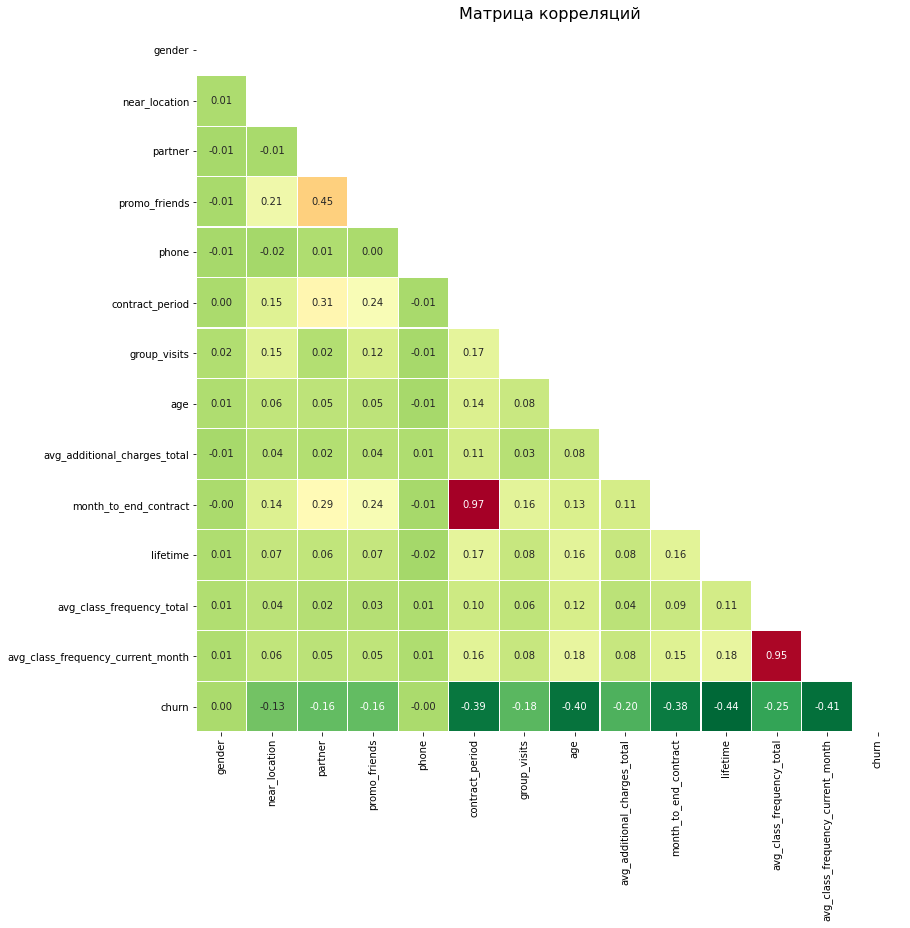

In [8]:
# построим матрицу корреляций
cm = data.corr()
mask = np.triu(cm)
plt.figure(figsize=(13,13))
plt.title('Матрица корреляций', fontsize=16)
sns.heatmap(cm, 
            annot = True, 
            square = True, 
            cmap = 'RdYlGn_r', 
            fmt = '0.2f', 
            linewidths = .1, 
            cbar = False, 
            mask = mask);

В матрице присутствуют две пары сильно коррелирующих между собой признаков. Чтобы избавиться от мультиколлинеарности, удалим по одному любому признаку из каждой пары.

In [9]:
data.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis=1, inplace=True)

От мультиколлинеарности избавились. Отдельно отметим достаточно сильную положительную корреляцию между сотрудником компании-партнёра клуба и клиента, который пришел по акции "Приведи друга".

**Промежуточный вывод**

На основании исследовательского анализа можно сформулировать первые гипотезы оттока посетителей сети фитнес-центра. Это касается клиентов, средний возраст которых составляет 27 лет, покупающих абонемент на 1 месяц и ходивших в зал максимум 1-2 месяца (судя по гистограмме lifetime). В среднем такие клиенты посещают 1 занятие в неделю или не посещают вообще.

# Построение модели прогнозирования оттока клиентов

In [10]:
# разделим данные на признаки (матрица X) и целевую переменную (y)
X = data.drop('churn', axis=1)
y = data['churn']

# разделим модель на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразуем обучающий и тестовые наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [11]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=0)

# обучим модель
lr_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]

# выведем все метрики
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]

# выведем все метрики
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса:'
)

Метрики для модели логистической регрессии:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.84
	F1: 0.84
	ROC_AUC: 0.97
Метрики для модели случайного леса:
	Accuracy: 0.91
	Precision: 0.85
	Recall: 0.77
	F1: 0.81
	ROC_AUC: 0.96


На основании метрик модель логистической регрессии показала себя лучше буквально по всем критериям. В целом, обе модели достаточно точно прогнозируют вероятность оттока пользователей (96-97%), на что указывает метрика ROC_AUC.

In [12]:
# выведем упорядоченный по модулю коэффициентов датафрейм с признаками
coef = abs(lr_model.coef_)
features = pd.DataFrame({'feature':X.columns, 'coef':coef.flatten()})
features.sort_values('coef', ascending=False)

,feature,coef
9,lifetime,3.649607
5,contract_period,1.406058
10,avg_class_frequency_current_month,1.294443
7,age,1.172619
8,avg_additional_charges_total,0.571324
6,group_visits,0.383113
3,promo_friends,0.153522
4,phone,0.076802
1,near_location,0.063778
2,partner,0.057374


Таким образом, наиболее важными признаками, влияющими на отток клиентов оказались:
- время с момента первого обращения в фитнес-центр (lifetime);
- длительность текущего действующего абонемента (contract_period);
- средняя частота посещений в неделю за предыдущий месяц (avg_class_frequency_current_month);
- возраст (age).

# Кластеризация клиентов

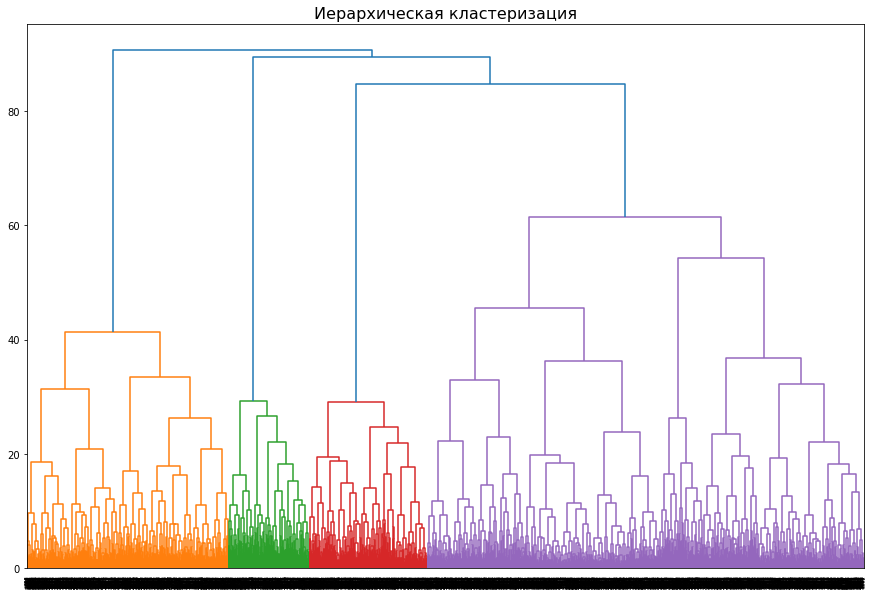

In [13]:
# обучаем нормализатор и преобразуем набор данных
x_sc = scaler.fit_transform(X)  

# строим матрицу расстояний
linked = linkage(x_sc, method = 'ward')

# рисуем дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация', fontsize=16)
plt.show()

На основании дендрограммы оптимально выделить 4 кластера (4 разных цвета на графике), однако для учебных целей при расчете модели KMeans необходимо взять 5 кластеров, чтобы можно было сравнить полученные результаты с остальными студентами.

In [14]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters = 5, random_state = 0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
data['cluster_km'] = labels

# проверим количество примеров в кластерах
data.groupby('cluster_km')['cluster_km'].count()

cluster_km
0     985
1     558
2    1064
3    1007
4     386
Name: cluster_km, dtype: int64

Основное количество наблюдений сосредоточено на кластерах под номерами 2 и 3, что составляет 51.8% от общей доли. На долю самого малого кластера под номером 4 приходится 9.7% всех наблюдений. В целом, наблюдения по кластерам разбились адекватно, аномально высоких или аномально низких значений не имеется.

In [15]:
# выводим статистику по средним значениям наших признаков по каждому кластеру
cluster_features = data.groupby('cluster_km').mean()
display(cluster_features.T.style.background_gradient(cmap='YlOrRd', axis=1).set_precision(2))

cluster_km,0,1,2,3,4
gender,0.50,0.50,0.50,0.53,0.52
near_location,1.00,0.00,1.00,1.00,0.86
partner,0.89,0.49,0.22,0.38,0.47
promo_friends,1.00,0.08,0.07,0.01,0.31
phone,1.00,1.00,1.00,1.00,0.00
contract_period,6.92,2.99,2.01,6.21,4.78
group_visits,0.52,0.23,0.28,0.54,0.43
age,29.61,28.68,27.58,30.70,29.30
avg_additional_charges_total,153.42,137.13,119.34,176.26,144.21
lifetime,4.28,2.97,1.92,5.42,3.94


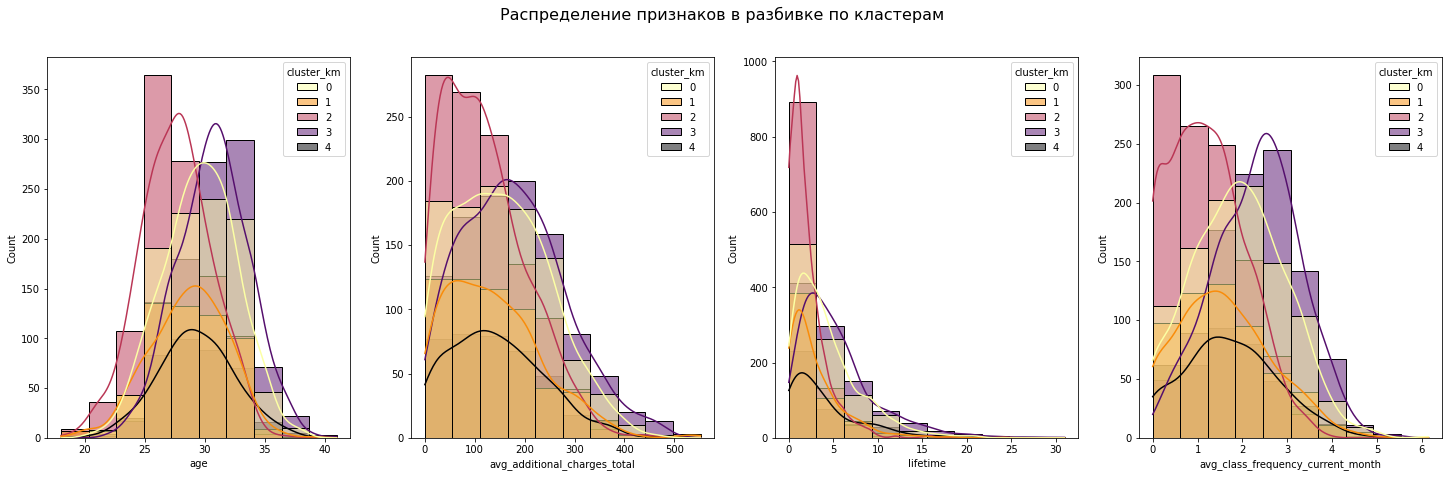

In [16]:
# построим графики распределений в разбивке по кластерам
num_features_3 = [
    'age',
    'avg_additional_charges_total',
    'lifetime',
    'avg_class_frequency_current_month'
]

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25, 7), squeeze=True)
fig.suptitle('Распределение признаков в разбивке по кластерам', fontsize=16)
for i in range(len(num_features_3)):
    sns.histplot(data,
                 x = num_features_3[i],
                 kde = True,
                 hue = 'cluster_km',
                 ax = axes.flatten()[i],
                 palette = 'inferno_r',
                 bins = 10)

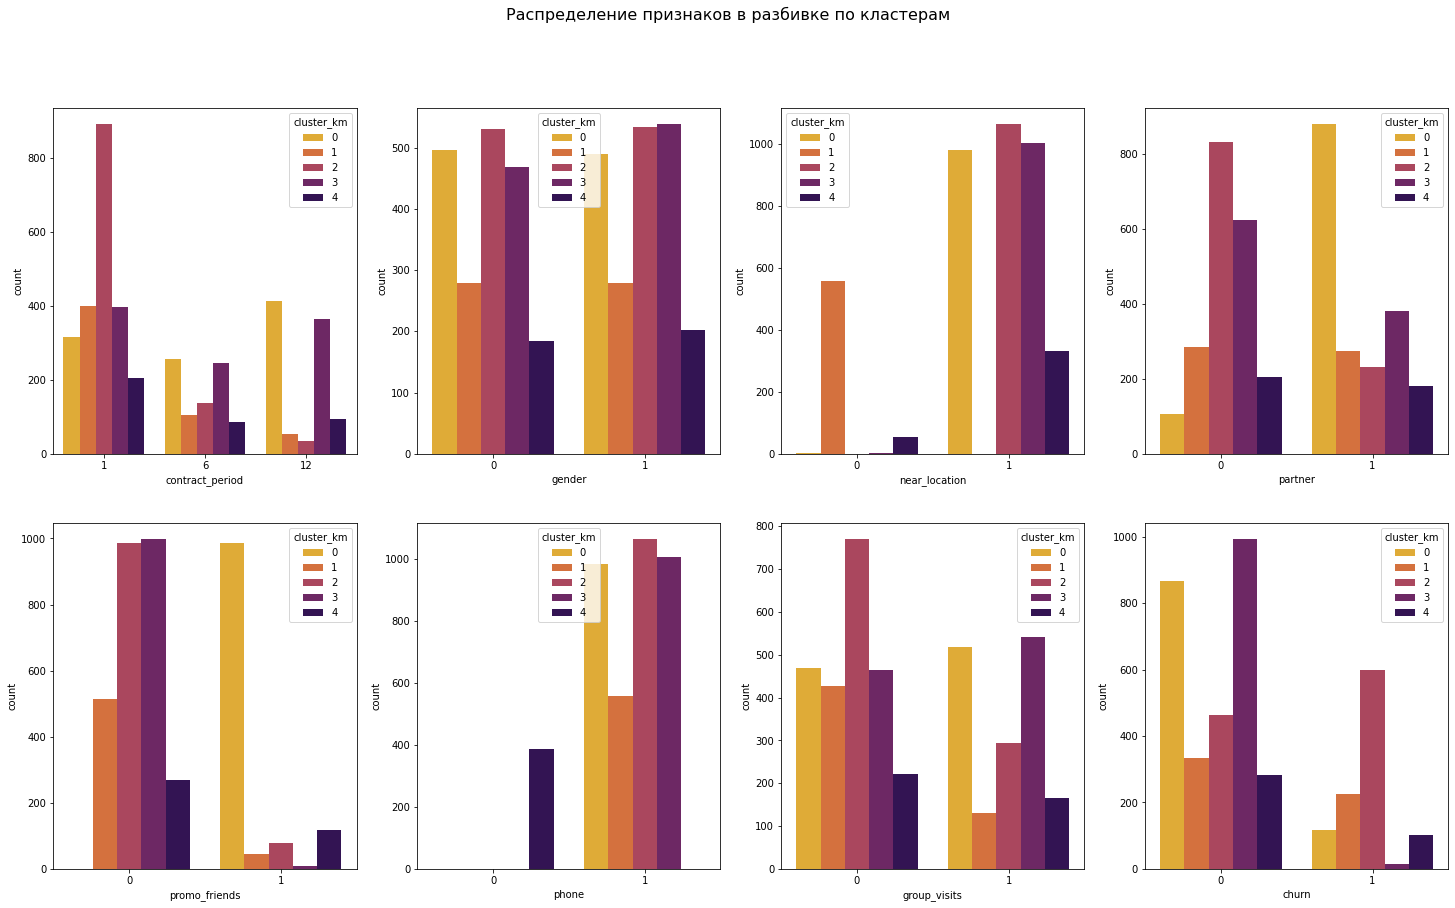

In [17]:
# построим графики распределений в разбивке по кластерам 
num_features_4 = [
    'contract_period',
    'gender',
    'near_location',
    'partner',
    'promo_friends',
    'phone',
    'group_visits',
    'churn'
]

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(25, 14), squeeze=True)
fig.suptitle('Распределение признаков в разбивке по кластерам', fontsize=16)
for i in range(len(num_features_4)):
    sns.countplot(data = data,
                  x = num_features_4[i],
                  hue = 'cluster_km',
                  ax = axes.flatten()[i],
                  palette = 'inferno_r')

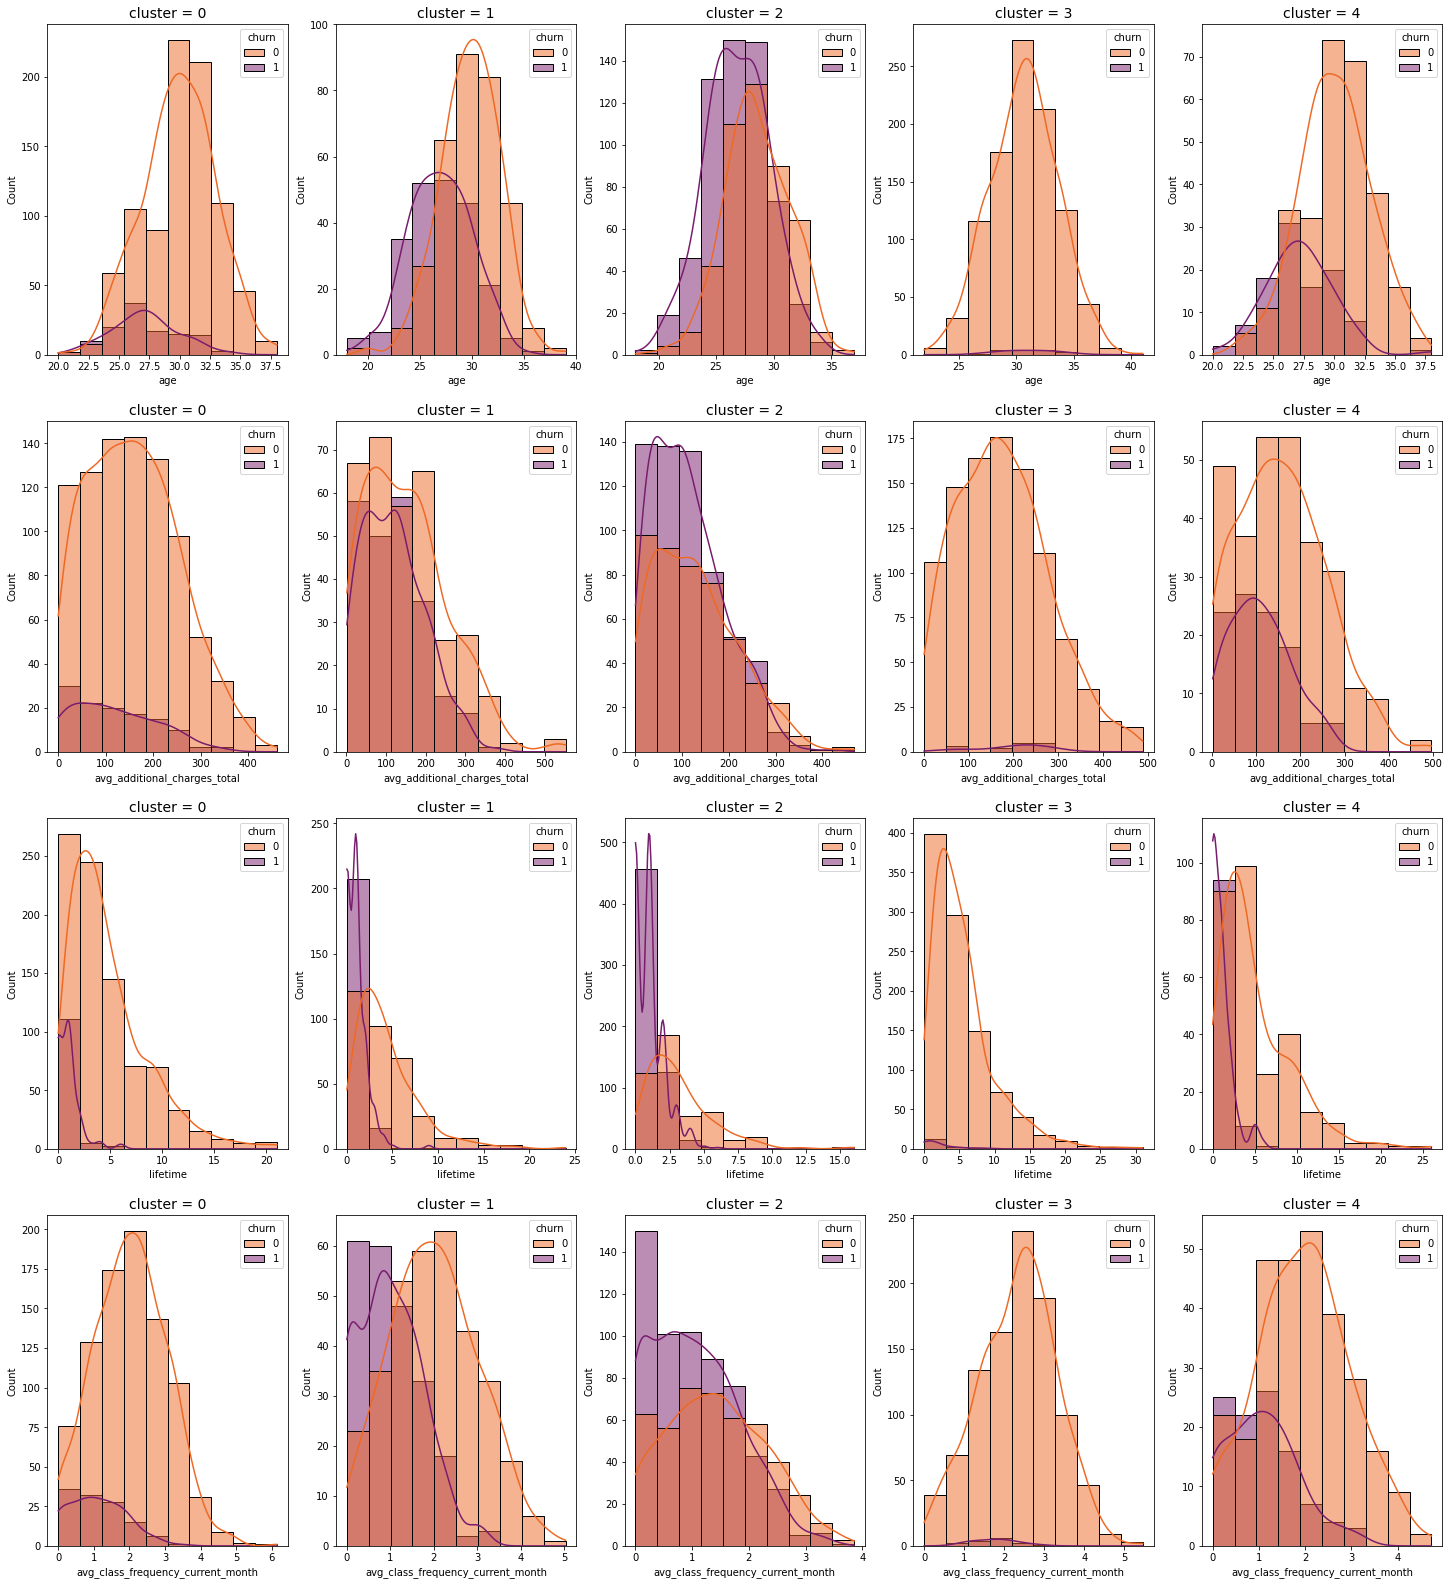

In [18]:
# построим распределение признаков для каждого кластера для тех, кто ушел и тех, кто остался
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(25, 28), squeeze=True)
for i in range(len(num_features_3)):
    for cluster in range(5): 
        sns.histplot(data[data['cluster_km'] == cluster],
                     x = num_features_3[i],
                     hue = 'churn',
                     ax = axes[i][cluster],
                     legend = True,
                     bins = 10,
                     kde = True,
                     palette = 'inferno_r')
        axes[i][cluster].set_title('cluster = {}'.format(cluster), fontsize=14)

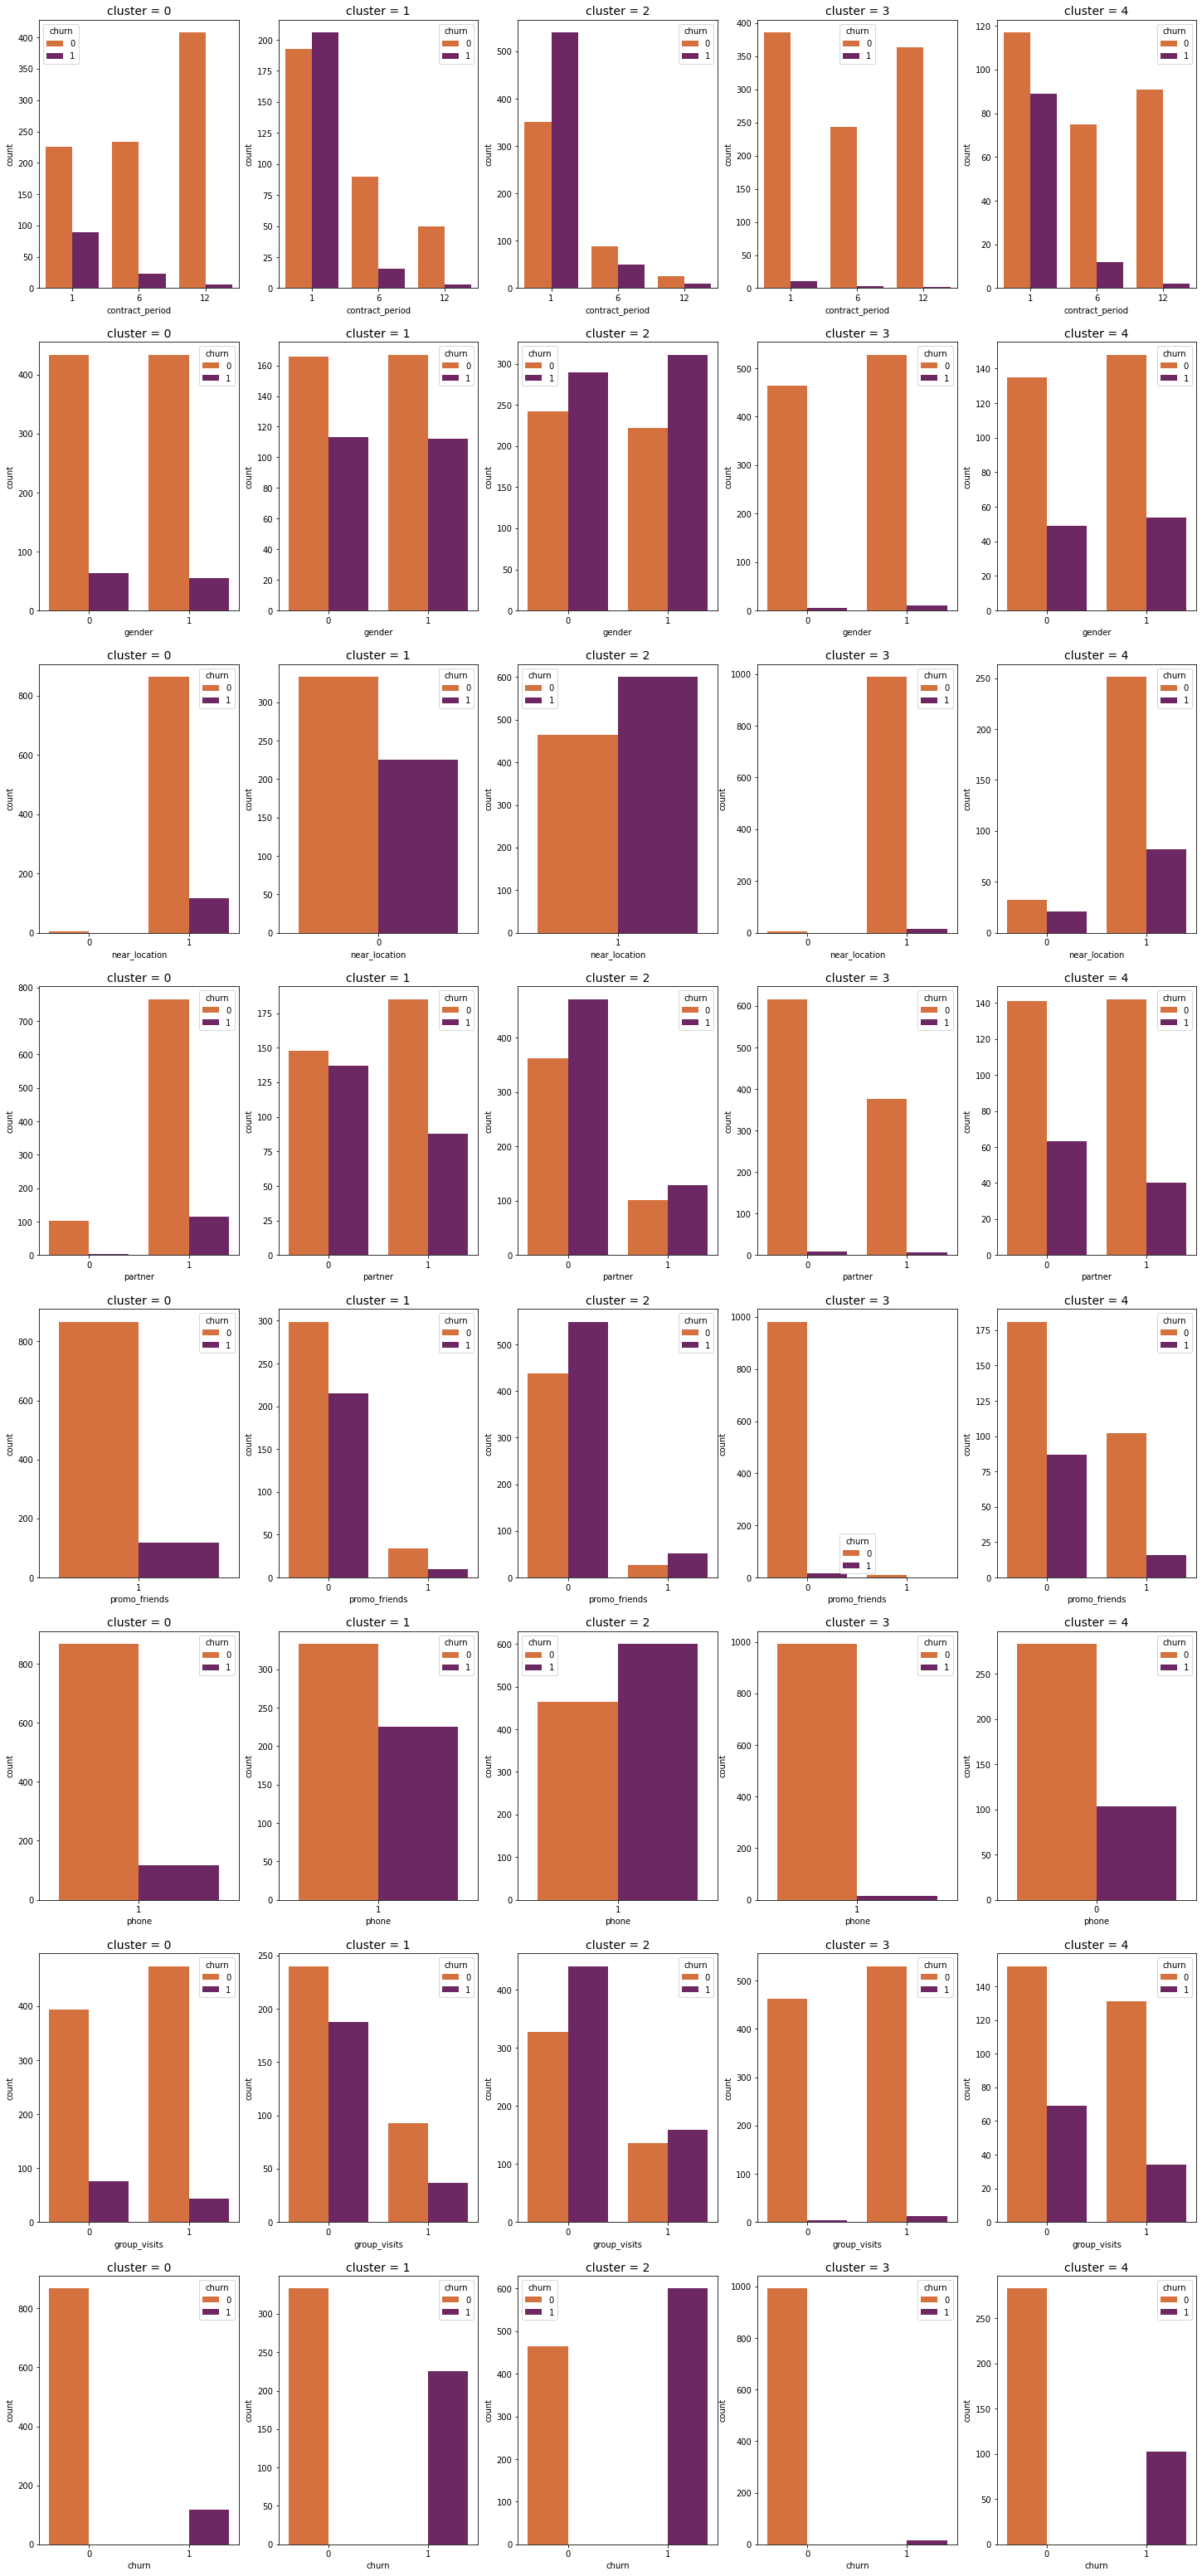

In [19]:
# построим распределение признаков для каждого кластера для тех, кто ушел и тех, кто остался
fig, axes = plt.subplots(nrows=8, ncols=5, figsize=(25, 56), squeeze=True)
for i in range(len(num_features_4)):
    for cluster in range(5): 
        sns.countplot(data = data[data['cluster_km'] == cluster],
                      x = num_features_4[i],
                      hue = 'churn',
                      ax = axes[i][cluster],
                      palette = 'inferno_r')
        axes[i][cluster].set_title('cluster = {}'.format(cluster), fontsize=14)

Характерные черты каждого кластера:

**Кластер 0 - "Пользователи, которые пришли в рамках акции «Приведи друга»":**
- Кол-во 985 (24,6% от общего кол-ва)
- Отток - 12% (ниже среднего)
- Все клиенты пришли по акции "Приведи друга"
- Средняя длительность текущего действующего абонемента - 7 мес.
- В 89% случаев является сотрудником компании-партнера
- В 52% случаев клиенты посещают групповые занятия

**Кластер 1 - "Проживающие в другом районе":**
- Кол-во 558 (14% от общего кол-ва)
- Отток - 40% (выше среднего)
- Все клиенты проживают в другом районе
- Средняя длительность текущего действующего абонемента - 3 мес.
- Среднее время с момента первого обращения в фитнес-центр тоже - 3 мес.
- Групповые занятия посещают только 23% клиентов (самый низкий уровень)

**Кластер 2 - "Самые нелояльные клиенты":**
- Кол-во - 1064 (26,6% от общего кол-ва)
- Отток - 56% (самый высокий)
- Средняя длительность текущего действующего абонемента - 2 мес. (самый низкий уровень)
- Среднее время с момента первого обращения в фитнес-центр - 2 мес. (самый низкий уровень)
- Средняя посещаемость в неделю за последний месяц - 1 занятие (самый низкий уровень)
- Самые молодый клиенты, средний возраст - 27,5 лет

**Кластер 3 - "Самые лояльные клиенты":**
- Кол-во - 1007 (25% от общего кол-ва)
- Отток - 1% (самый низкий)
- По акции "Приведи друга" пришел только 1% пользователей (самый низкий уровень)
- Средняя длительность текущего действующего абонемента - 6 мес.
- Групповые занятие посещает 54% клиентов (самый высокий уровень)
- Самые возрастные клиенты, средний возраст - 30,7 лет
- Среднее время с момента первого обращения в фитнес-центр - 5,4 мес. (самый высокий уровень)
- Средняя посещаемость в неделю за последний месяц - 2,3 занятия (самый высокий уровень)
- Суммарная средняя выручка от других услуг фитнес-центра - 176,3 у.е. (самый высокий уровень)

**Кластер 4 - "Отсутствие контактного телефона":**
- Кол-во - 386 (9,7% от общего кол-ва)
- Отток - 27% (средний уровень)
- Никто из клиентов не указал контактный телефон

# Вывод и рекомендации

Исходные данные представлены в хорошем качестве, состоят из 4 тыс. строк и 14 столбцов, аномалий не обнаружено. По структуре данных видно, что большинство клиентов проживает в том же районе, где расположен фитнес центр (в среднем 84,5% клиентов). Возрастная категория представлена от 18 лет до 41 года, средний возраст клиента - 29 лет. Средняя посещаемость в неделю составляет 2 дня, а средний отток - 26,5% пользователей.

При построении матрицы корреляции были найдены две пары сильно коррелирующих между собой признаков. Чтобы избавиться от мультиколлинеарности, было принято решение удалить по одному любому признаку из каждой пары. Также была выявлена положительная зависимость между сотрудниками компании-партнёра клуба и клиентами, которые пришли по акции "Приведи друга". На основании исследовательского анализа была сформулирована гипотеза оттока посетителей сети фитнес-центра. Это касается клиентов, средний возраст которых составляет 27 лет, покупающих абонемент на 1 месяц и ходивших в зал максимум 1-2 месяца. В среднем такие клиенты посещают 1 занятие в неделю или не посещают вообще. Отдельно стоит отметить несбалансированность классов в пропорции приблизительно 1 к 3 (на 1 долю неактивных пользователей приходится 3 доли активных).

При построении модели прогнозирования оттока клиентов исходный набор данных был поделен на две части: первая часть - обучающая, с долей 80%; и вторая - тестовая, с долей 20%. Из-за существующего дисбаланса классов был использован параметр 'stratify', который позволил сохранить изначальное распределение целевого показателя (уровень оттока) во всех новых датасетах. В качестве моделей прогнозирования использовали логистическую регрессию и случайный лес. На основании метрик, модель логистической регрессии показала себя лучше по таким критериям как: Accuracy, Recall, F1 и ROC_AUC (метрика Precision осталась на том же уровне, что и у случайного леса). В целом, обе модели достаточно точно спрогнозировали вероятность оттока пользователей на уровне 96-97%.

В ходе кластеризации клиентов, на основании дендрограммы и модели K-Means, все пользователи распределились на 5 групп (кластеров):
- Кластер 0 для пришедших в рамках акции "Приведи друга"
- Кластер 1 для проживающих в другом районе
- Кластер 2 для самых нелояльных клиентов
- Кластер 3 для самый лояльных клиентов
- Кластер 4 для клиентов без контактного телефона.

По итогу работы гипотеза из исследовательского анализа практически полностью подтвердилась моделью, полученной с помощью кластеризации. Таким образом, наибольшее влияние на отток оказывают такие признаки как:
- время с момента первого обращения в фитнес-центр (lifetime) - новые клиенты хуже удерживаются;
- срок действующего абонемента (contract_period) - чем меньше времени до конца срока действия абонемента, тем выше риск оттока;
- плохая посещаемость (avg_class_frequency_current_month);
- возраст (age) - молодёж в среднем более подвержена оттоку;
- непосещение групповых занятий (group_visits).

Также было выяснено, что гендерная принадлежность, район проживания, клиенты по акции "Приведи друга", клиенты компаний-партнеров клуба и наличие контактного телефона не оказывают влияния на отток. 



В качестве рекомендаций можно предложить:
- активно продвигать продажи абонементов на длительный срок, делать акцент на скидках и бонусах в виде 2-3 бесплатных посещений массажа, 2-3 бесплатных консультаций с тренером, небольших скидок на сам абонемент или на смежную продукцию фитнес-центра. У клиентов не должно оставаться сомнений в выборе абонемента.
- для удержания молодежи можно также использовать систему скидок для студентов в зависимости от срока покупаемого абонемента. Также можно предоставить персональное занятие с тренером, составление программы тренировок и питания.
- важно стимулировать высокую посещаемость спортзала - в среднем 2-3 раза в неделю. Это можно сделать в виде игры, где в конце месяца самым упорным и мотивированным фитнес-центр будет дарить подарки в виде брендированной одежды/канцтоваров/спорттоваров и тд.
- перед тем, как закончится абонемент у действующего клиента, можно заранее (за 2-3 недели) делать персональные предложения, отличающиеся своей выгодой от стандартного пакета услуг.
- также было бы полезно собирать отзывы о фитнес-центре у новых клиентов, купивших абонемент на 1 месяц, спустя 3 недели занятий, чтобы узнать, все ли им нравится, а если не нравится, то что именно. Возможно, такой разговор принесет инсайт в бизнес или позволит решить возникшую конфликтную ситуацию у клиента, да и просто смотивировать его на дальнейшее сотрудничество. Только это должен делать живой человек, а не робот, иначе эффект может быть противоположным.
- обратить больше внимания на уже существующую акцию "Пригласи друга", возможно, стоит пересмотреть мотивацию, например: предлагать месяц занятий в подарок каждому или одно бесплатное посещение салона красоты/бани и т.д.(можно на выбор) от компаний-партнеров.
- стимулировать посещение групповых занятий, акцентировать внимание на эмоциях, новых знакомствах, хорошей физической форме и здоровом образе жизни. Все это будет способствовать росту увлеченности клиентов и положительно скажется на их посещаемости.